25/08/08 14:31:32 WARN Utils: Your hostname, DESKTOP-15VE119 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/08 14:31:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/08 14:31:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


--- Data Loading (CPU) ---


Data load time (CPU): 8.30 seconds
data schema:
root
 |-- Id: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Body: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- Y: string (nullable = true)

Y column distribution after load (should be HQ, LQ_EDIT, LQ_CLOSE):


+--------+-----+
|       Y|count|
+--------+-----+
|LQ_CLOSE|15000|
|      HQ|15000|
| LQ_EDIT|15000|
+--------+-----+

--- Data Cleaning and Feature Engineering (initial steps - CPU) ---
Initial data cleaning and feature engineering time (CPU): 0.46 seconds


Train data count (CPU): 35997, Test data count (CPU): 9003

--- Logistic Regression Training (CPU) ---


25/08/08 14:33:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:41 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:55 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:55 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:56 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:56 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:58 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:58 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/08/08 14:33:58 WARN DAGScheduler: Broadcasting larg

Logistic Regression training time (CPU): 119.54 seconds
Logistic Regression prediction time (CPU): 0.46 seconds


25/08/08 14:34:00 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
25/08/08 14:34:03 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
25/08/08 14:34:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB



Logistic Regression Results (CPU):
Accuracy: 0.7050
F1 Score: 0.7047
Confusion Matrix (CPU):


25/08/08 14:34:10 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
                                                                                

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1941|
|  0.0|       1.0|  601|
|  0.0|       2.0|  435|
|  1.0|       0.0|  758|
|  1.0|       1.0| 1955|
|  1.0|       2.0|  267|
|  2.0|       0.0|  404|
|  2.0|       1.0|  191|
|  2.0|       2.0| 2451|
+-----+----------+-----+



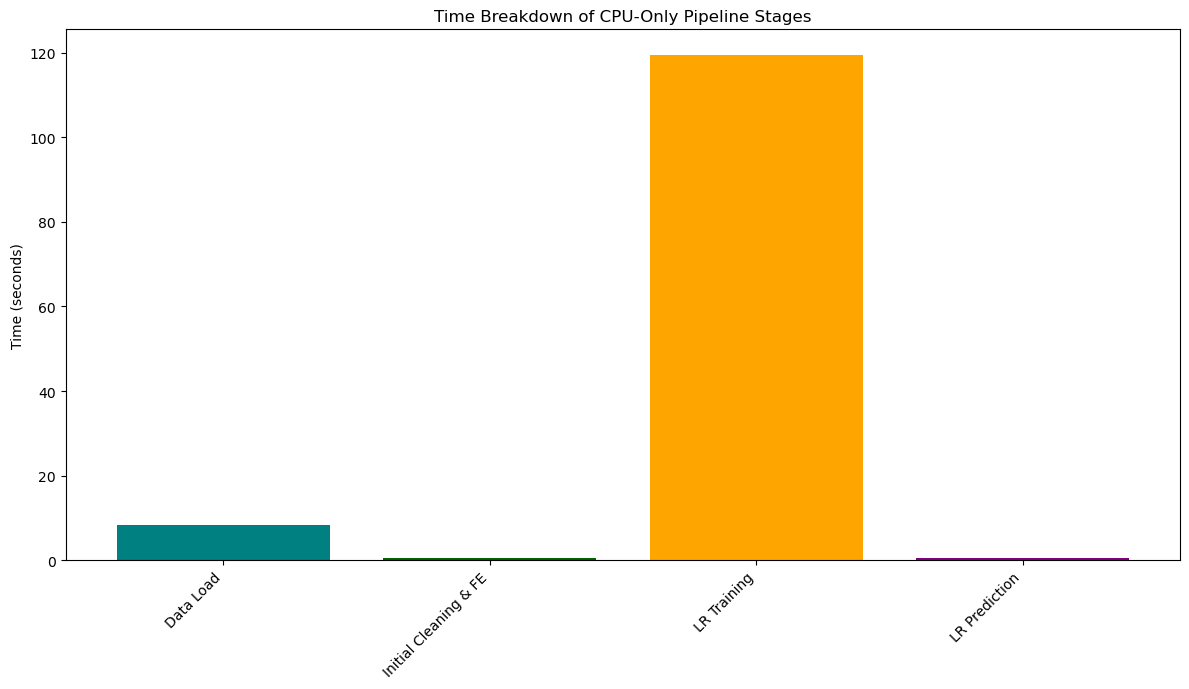

25/08/08 14:34:11 WARN DAGScheduler: Broadcasting large task binary with size 1898.6 KiB
                                                                                

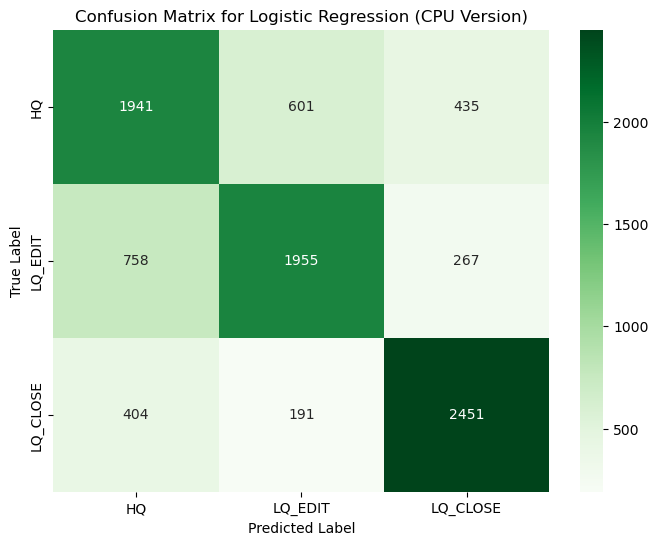

In [1]:
import re
import traceback
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, concat_ws, regexp_replace, size, split, when, lit, expr
from pyspark.sql.types import StringType, IntegerType, DoubleType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StopWordsRemover, HashingTF, IDF, VectorAssembler, NGram, Word2Vec, StringIndexer 
)

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

spark = (SparkSession.builder
    .appName("CPU_Only_Spark")
    .master("local[*]")
    .config("spark.driver.memory","24g")
    .config("spark.executor.memory", "24g")
    .config("spark.executor.cores", "4")
    .config("spark.driver.cores", "4")
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.driver.host", "localhost")
    .config("spark.rapids.sql.enabled", "false") 
    .config("spark.memory.offHeap.enabled", "false") 
    .config("spark.sql.session.timeZone", "UTC")
    .config("spark.sql.rowBasedUDF.enabled", "true") 
    .getOrCreate()
)

data_path = "/mnt/c/Users/BerenÜnveren/Desktop/BIL401/data/train.csv"
try:
    print("--- Data Loading (CPU) ---")
    start_load_time = time.time()

    df = spark.read.format("csv") \
        .option("header", "true") \
        .option("quote", "\"") \
        .option("escape", "\"") \
        .option("multiLine", "true") \
        .option("inferSchema", "true") \
        .load(data_path)
    load_time = time.time() - start_load_time
    print(f"Data load time (CPU): {load_time:.2f} seconds")
    print("data schema:")
    df.printSchema()
    print("Y column distribution after load (should be HQ, LQ_EDIT, LQ_CLOSE):")
    df.groupBy("Y").count().show()

    print("--- Data Cleaning and Feature Engineering (initial steps - CPU) ---")
    start_clean_feature_time = time.time()

    df_clean = df.na.drop(subset=["Title", "Body", "Tags", "Y"]) \
        .withColumn("CleanBody", regexp_replace(col("Body"), "<.*?>", "")) \
        .withColumn("text", concat_ws(" ", col("Title"), col("CleanBody")))

    df_clean = df_clean.withColumn("tags_list",split(expr("TRIM(REPLACE(REPLACE(Tags, '<', ' '), '>', ' '))")," "))

    df_featured = df_clean.withColumn("title_len", length(col("Title"))) \
        .withColumn("body_len", length(col("CleanBody"))) \
        .withColumn("punct_count", length(regexp_replace(col("text"), "[?!]", ""))) \
        .withColumn("avg_word_len", 
                    length(regexp_replace(col("text"), " ", "")).cast(DoubleType()) / \
                    (size(split(col("text"), " ")) + lit(1e-6)))

    clean_feature_time = time.time() - start_clean_feature_time
    print(f"Initial data cleaning and feature engineering time (CPU): {clean_feature_time:.2f} seconds")
    
    label_indexer = StringIndexer(inputCol="Y", outputCol="label", handleInvalid="skip")
    df_processed = df_featured.withColumn("words", split(col("text"), " ")) 
    stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    ngram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")
    hashing_tf_text = HashingTF(inputCol="filtered_words", outputCol="raw_text_features", numFeatures=20000)
    idf_text = IDF(inputCol="raw_text_features", outputCol="text_features")
    
    hashing_tf_bigrams = HashingTF(inputCol="bigrams", outputCol="raw_bigrams_features", numFeatures=20000)
    idf_bigrams = IDF(inputCol="raw_bigrams_features", outputCol="bigrams_features")
    
    w2v = Word2Vec(vectorSize=100, minCount=5, inputCol="filtered_words", outputCol="w2v_features")
    hashing_tf_tags = HashingTF(inputCol="tags_list", outputCol="raw_tags_features", numFeatures=5000)
    idf_tags = IDF(inputCol="raw_tags_features", outputCol="tags_tags")

    feature_assembler = VectorAssembler(
        inputCols=["text_features", "bigrams_features", "w2v_features", "tags_tags",
                   "title_len", "body_len", "punct_count", "avg_word_len"],
        outputCol="features"
    )

    (train_data, test_data) = df_processed.randomSplit([0.8, 0.2], seed=42)

    train_data.cache()
    test_data.cache()
    train_data.count()
    test_data.count()
    
    print(f"Train data count (CPU): {train_data.count()}, Test data count (CPU): {test_data.count()}")
    print("\n--- Logistic Regression Training (CPU) ---")    
    
    lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10) 
    lr_pipeline = Pipeline(stages=[
        label_indexer, 
        stopwords_remover,
        ngram,
        hashing_tf_text, idf_text,
        hashing_tf_bigrams, idf_bigrams,
        w2v,
        hashing_tf_tags, idf_tags,
        feature_assembler,
        lr
    ])

    start_lr_train_time = time.time()
    lr_model = lr_pipeline.fit(train_data)
    lr_train_time = time.time() - start_lr_train_time
    print(f"Logistic Regression training time (CPU): {lr_train_time:.2f} seconds")

    start_lr_predict_time = time.time()
    lr_predictions = lr_model.transform(test_data)
    lr_predict_time = time.time() - start_lr_predict_time
    print(f"Logistic Regression prediction time (CPU): {lr_predict_time:.2f} seconds")

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    accuracy_lr = evaluator.setMetricName("accuracy").evaluate(lr_predictions)
    f1_score_lr = evaluator.setMetricName("f1").evaluate(lr_predictions)

    print("\nLogistic Regression Results (CPU):")
    print(f"Accuracy: {accuracy_lr:.4f}")
    print(f"F1 Score: {f1_score_lr:.4f}")
    print("Confusion Matrix (CPU):")
    lr_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

    try:
        times_cpu = {
            "Data Load": load_time,
            "Initial Cleaning & FE": clean_feature_time,
            "LR Training": lr_train_time,
            "LR Prediction": lr_predict_time
        }

        labels_cpu = list(times_cpu.keys())
        values_cpu = list(times_cpu.values())

        plt.figure(figsize=(12, 7))
        plt.bar(labels_cpu, values_cpu, color=['teal', 'darkgreen', 'orange', 'purple'])
        plt.ylabel("Time (seconds)")
        plt.title("Time Breakdown of CPU-Only Pipeline Stages")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig("cpu_pipeline_time_breakdown.png") 
        plt.show()
    except NameError:
        print("Time tracking variables for CPU not defined, skipping time breakdown plot.")
    except Exception as e:
        print(f"Error generating CPU time breakdown plot: {e}")
        traceback.print_exc()

    try:        
        predictions_pd = lr_predictions.select("label", "prediction").toPandas()
        cm = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])
        class_labels = ["HQ", "LQ_EDIT", "LQ_CLOSE"]

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix for Logistic Regression (CPU Version)")
        plt.savefig("cpu_confusion_matrix_lr.png") 
        plt.show()

    except Exception as e:
        print(f"Error generating CPU confusion matrix plot: {e}")
        traceback.print_exc()

except Exception as e:
    print(f"An error occurred: {e}")
    traceback.print_exc()
finally:
    try:
        if 'spark' in locals() and spark is not None:
            spark.stop()
    except Exception as e:
        print(f"Error stopping Spark session: {e}")
        traceback.print_exc()